# core

> Some utility functions for working with PyTorch

In [ ]:
#| default_exp core

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
# Import necessary modules from the standard library
from pathlib import Path  # For working with file paths
import logging  # For logging messages
import hashlib
import random

# Disable logging warnings
logging.disable(logging.WARNING)

import numpy as np  # For working with arrays

from PIL import Image  # For working with images

import torch  # PyTorch module for deep learning
from torchvision import transforms  # PyTorch module for image transformations

In [ ]:
#| export
def set_seed(seed: int, # The seed value to be set for all random number generators.
             deterministic: bool = False # If True, uses deterministic algorithms in PyTorch where possible for reproducibility, at the cost of performance.
            ) -> None:
    """
    Sets the seed for generating random numbers in PyTorch, NumPy, and Python's random module.

    This function is used for reproducibility in stochastic operations, e.g. shuffling in data loaders,
    random initializations in neural networks, etc.

    Note: The deterministic flag does not guarantee complete reproducibility. Operations which rely on CUDA might
    still produce non-deterministic results.
    """
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.use_deterministic_algorithms(deterministic)

In [ ]:
seed = 1234
set_seed(seed)

In [ ]:
#| export
def pil_to_tensor(img:Image, # The input PIL image.
                  mean=[0.485, 0.456, 0.406], # The mean values for normalization.
                  std=[0.229, 0.224, 0.225] # The standard deviation values for normalization.
                 ):
    """
    Converts a PIL image to a normalized and batched PyTorch tensor.
    
    Returns:
        The normalized and batched tensor.
    """
    
    return transforms.Normalize(mean, std)(transforms.ToTensor()(img))[None]

**Set the path for the images directory**

In [ ]:
img_dir = Path('../images/')
img_dir

Path('../images')

**Open sample image**

Image Size: (768, 512)


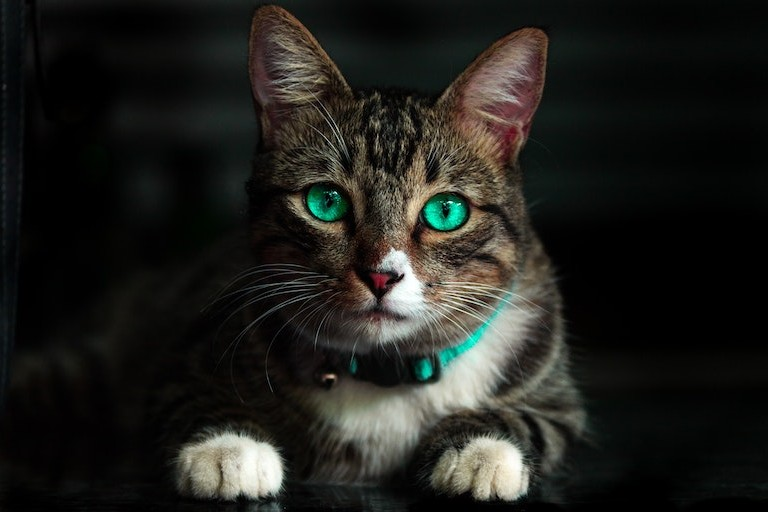

In [ ]:
img_path = '../images/cat.jpg'
src_img = Image.open(img_path).convert('RGB')
print(f"Image Size: {src_img.size}")
src_img

**Convert image to tensor**

In [ ]:
img_tensor = pil_to_tensor(src_img, [0.5], [0.5])
img_tensor.shape, img_tensor.min(), img_tensor.max()

(torch.Size([1, 3, 512, 768]), tensor(-1.), tensor(1.))

In [ ]:
#| export
def tensor_to_pil(tensor: torch.Tensor # The tensor to be converted
                 ):
    """
    Convert a tensor to a PIL image.
    
    Returns:
    img (PIL.Image): The PIL image
    """
    
    # Remove the first dimension if the tensor has 4 dimensions
    if len(tensor.shape) == 4: tensor.squeeze_(0)
        
    # Use the ToPILImage() function from the transforms module to convert the tensor to a PIL image
    return transforms.ToPILImage()(tensor)

**Convert tensor to image**

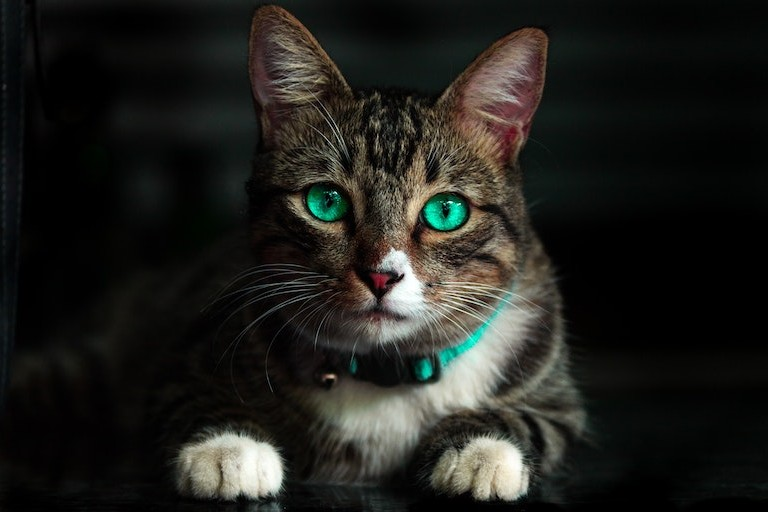

In [ ]:
tensor_img = tensor_to_pil(transforms.ToTensor()(src_img))
tensor_img

In [ ]:
#| export
def iterate_modules(module: torch.nn.Module): # A PyTorch module that contains child modules to be iterated over.
    """
    A generator function that yields the children and grandchildren of a PyTorch module.    
    """
    
    for child in module.children():
        yield child
        yield from iterate_modules(child)

In [ ]:
from torchvision import models

vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features

for index, module in enumerate(iterate_modules(vgg)):
    if type(module) == torch.nn.modules.activation.ReLU:
        print(f"{index}: {module}")

1: ReLU(inplace=True)
3: ReLU(inplace=True)
6: ReLU(inplace=True)
8: ReLU(inplace=True)
11: ReLU(inplace=True)
13: ReLU(inplace=True)
15: ReLU(inplace=True)
18: ReLU(inplace=True)
20: ReLU(inplace=True)
22: ReLU(inplace=True)
25: ReLU(inplace=True)
27: ReLU(inplace=True)
29: ReLU(inplace=True)


In [ ]:
#| export
import pandas as pd

In [ ]:
#| export
def tensor_stats_df(tensor, # Input tensor for which statistics are to be calculated.
                    attrs = ["mean", "std", "min", "max"], # List of statistics to be calculated.
                    shape=True): # If True, include shape of the tensor in the output.
    """
    Calculate and return statistics of a given tensor as a pandas DataFrame.
    """
    
    attr_dict = {attr: getattr(tensor, attr)().item() for attr in attrs}
    if shape: attr_dict["shape"] = tensor.shape
    return pd.DataFrame.from_dict(attr_dict, orient='index')

In [ ]:
tensor_stats_df(torch.randn(1, 3, 256, 256))

,0
mean,0.003342
std,0.99868
min,-4.558271
max,4.815985
shape,"(1, 3, 256, 256)"


In [ ]:
#| export
def get_torch_device():
    """
    This function returns the device to be used for PyTorch computations.
    
    Returns:
    str: "mps" if Metal Performance Shaders (MPS) for MacOS is available, 
         "cuda" if CUDA is available, 
         "cpu" otherwise
    """
    device = (
        "mps"
        if torch.backends.mps.is_available()
        else "cuda"
        if torch.cuda.is_available()
        else "cpu"
    )
    return device

In [ ]:
get_torch_device()

'cuda'

In [ ]:
#| export
def denorm_img_tensor(img_tensor:torch.Tensor, # The tensor representing the normalized image.
                      mean:list, # The mean values used for normalization.
                      std:list): # The standard deviation values used for normalization.
    """
    Denormalize an image tensor.
    
    Returns:
        torch.Tensor: The tensor representing the denormalized image.
    """
    # Convert the mean and standard deviation values to tensors
    mean_tensor = torch.Tensor(mean).view(1,1,-1).permute(2, 0, 1)
    std_tensor = torch.Tensor(std).view(1,1,-1).permute(2, 0, 1)
    # Denormalize the image tensor
    return img_tensor*std_tensor+mean_tensor

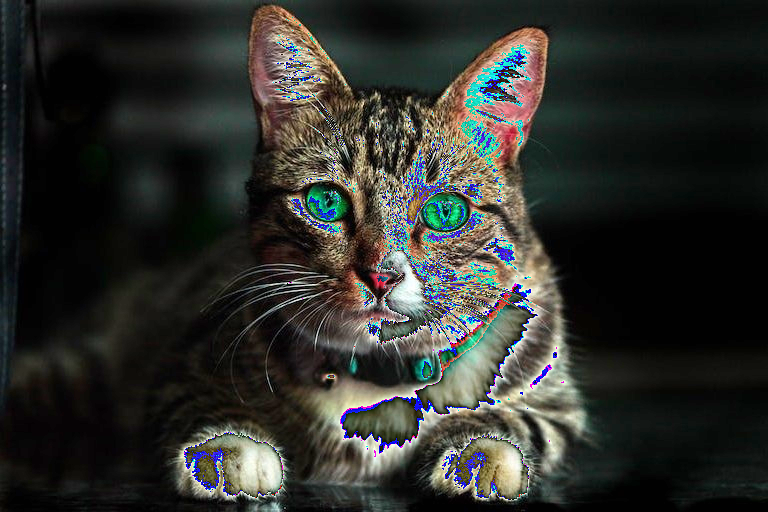

In [ ]:
tensor_to_pil(img_tensor)

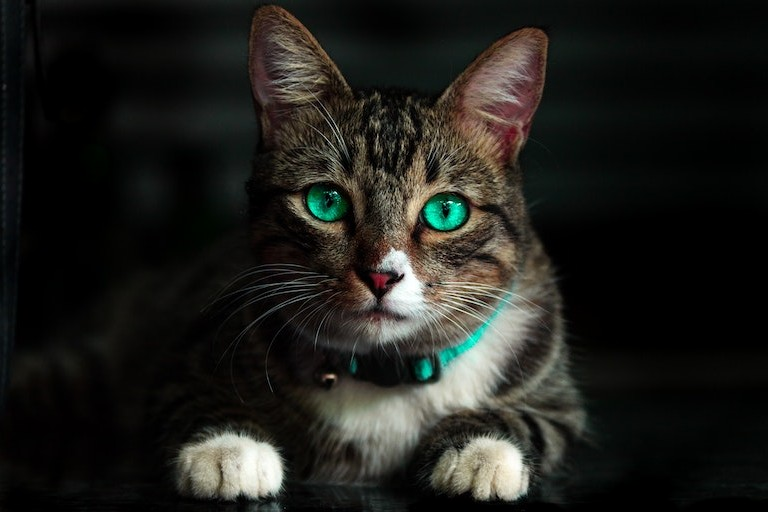

In [ ]:
tensor_to_pil(denorm_img_tensor(img_tensor, [0.5], [0.5]))

In [ ]:
#| export
def move_data_to_device(data, # Data to move to the device.
                        device:torch.device # The PyTorch device to move the data to.
                       ): # Moved data with the same structure as the input but residing on the specified device.
    """
    Recursively move data to the specified device.

    This function takes a data structure (could be a tensor, list, tuple, or dictionary)
    and moves all tensors within the structure to the given PyTorch device.

    Returns:
    - 
    """
    
    # If the data is a tuple, iterate through its elements and move each to the device.
    if isinstance(data, tuple):
        return tuple(move_data_to_device(d, device) for d in data)
    
    # If the data is a list, iterate through its elements and move each to the device.
    if isinstance(data, list):
        return list(move_data_to_device(d, device) for d in data)
    
    # If the data is a dictionary, iterate through its key-value pairs and move each value to the device.
    elif isinstance(data, dict):
        return {k: move_data_to_device(v, device) for k, v in data.items()}
    
    # If the data is a tensor, directly move it to the device.
    elif isinstance(data, torch.Tensor):
        return data.to(device)
    
    # If the data type is not a tensor, list, tuple, or dictionary, it remains unchanged.
    else:
        return data

In [ ]:
data_tuple = (
    {
        'masks': torch.tensor([[[0, 0, 0], [0, 0, 0], [0, 0, 0]]], dtype=torch.int32),
        'boxes': torch.tensor([[19.9176, 246.6063, 512.0000, 438.8571]]),
        'labels': torch.tensor([0.]),
    },
    {
        'masks': torch.tensor([[[0, 0, 0], [0, 0, 0], [0, 0, 0]]], dtype=torch.int32),
        'boxes': torch.tensor([[19.9176, 246.6063, 512.0000, 438.8571]]),
        'labels': torch.tensor([0.]),
    },
)

move_data_to_device(data_tuple, 'cpu')

({'masks': tensor([[[0, 0, 0],
           [0, 0, 0],
           [0, 0, 0]]], dtype=torch.int32),
  'boxes': tensor([[ 19.9176, 246.6063, 512.0000, 438.8571]]),
  'labels': tensor([0.])},
 {'masks': tensor([[[0, 0, 0],
           [0, 0, 0],
           [0, 0, 0]]], dtype=torch.int32),
  'boxes': tensor([[ 19.9176, 246.6063, 512.0000, 438.8571]]),
  'labels': tensor([0.])})

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()